## Applying a spatial filter to create a Sobel Operator

### Introduction
In this tutorial, we'll be developing a Sobel operator that is used commonly in computer vision and edge detection projects. You can read more here: https://en.wikipedia.org/wiki/Sobel_operator.


### Method

1. Let us begin by importing modules such as gdal, rasterio and other built-in customized modules. These are custom methods that we reviewed in Tutorial 1 for converting rasters to numpy arrays and vice versa. These methods are stored in the 'Utils' folder in the parent directory of this repository and can be re-used by improting them.


In [1]:
import gdal
import rasterio
import numpy as np
import os
import matplotlib.pyplot as plt
from rasterio.plot import show
from Utils.np2ras2np import nparray2ras, raster2nparray

### Data

The data we'll be using is a digital elevation model (DEM) derived from the National Elevation Dataset (NED) that can be downloaded from the National Map Viewer here: https://viewer.nationalmap.gov/. This is a single band raster dataset. 
_Data Citation_ U.S. Geological Survey, 20190924, USGS 13 arc-second n35w118 1 x 1 degree: U.S. Geological Survey.

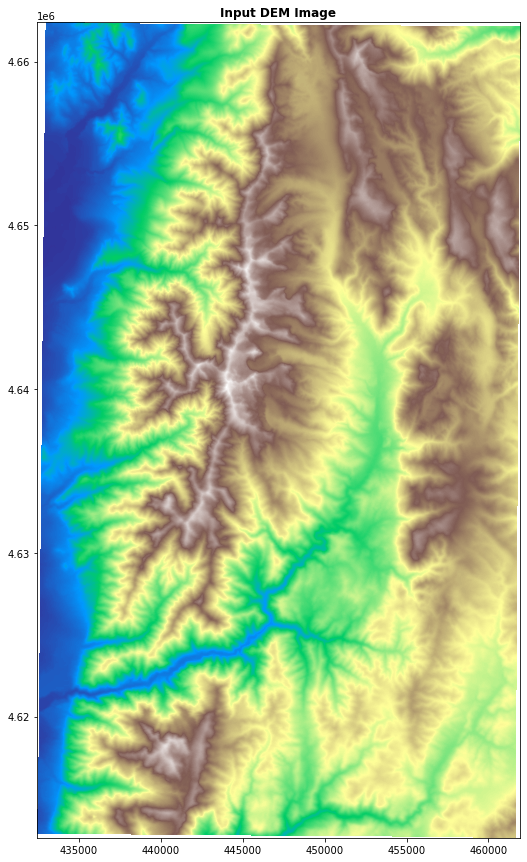

In [2]:
input_dem = os.path.join(
        os.getcwd(), 
        r'Data/Logan/logan.tif'
    )

input_src = rasterio.open(input_dem)
plt.figure(figsize=(15,15))
show(input_src, cmap = "terrain", title = "Input DEM Image")
plt.show()

Let us inspect the NoDataValue of the input raster as this is important while writing the script to apply Sobel operators on this DEM dataset.

In [3]:
input_src.nodata

-3.4028234663852886e+38

We'll use two kernels in a 3 x 3 moving window that'll be used to apply the sobel operator on the DEM data. These are vertical and horizontal weights that'll be applied within a moving window on the input raster dataset. 

In [4]:
Gx = np.array([[1, 0, -1],
              [2, 0, -2],
              [1, 0, -1]])

Gy = np.array([[1, 2, 1],
              [0, 0, 0],
              [-1, -2, -1]])

Now lets the built-in utility methods 'ras2nparray' to convert the input raster to a numpy array 

In [5]:
dem_array, originX, originY, cellsize, spatialref, ndvals = raster2nparray(input_dem)

In [6]:
n_row = dem_array.shape[1]
n_col = dem_array.shape[2]
dem_array.shape

(1, 1660, 985)

Create an empty array to store output raster values

In [7]:
sobel_array = np.empty(dem_array.shape)

### Analysis step

Let us apply the Sobel filter to the input raster. We'll create a 3 * 3 moving window and use relative row and column indices [-1, 0, 1] to visit each cell in the kernel. 

In [8]:
# Loop through each raster cell
for row in range(n_row - 1):
    for col in range(n_col - 1):
        sum_Gx = 0
        sum_Gy = 0
        nodata_in_window = False
        
        # Create a moving window at each cell:
        for i in [-1, 0, 1]:
            for j in [-1, 0, 1]:
                # Check for NoData
                if nodata_in_window == False and dem_array[0, row+i, col+j] != ndvals[0]:
                    sum_Gx += dem_array[0, row+i, col+j] * Gx[i+1, j+1]
                    sum_Gy += dem_array[0, row+i, col+j] * Gy[i+1, j+1]
                elif dem_array[0, row+i, col+j] == ndvals[0]:
                    nodata_in_window = True
        if nodata_in_window == False:
            sobel_array[0, row, col] = (sum_Gx**2 + sum_Gy**2)**0.5
        else:
            sobel_array[0, row, col] = ndvals[0]

Use the 'nparray2ras' method to save it to an output raster.

In [9]:
out_sobel_raster = os.path.join(
        os.getcwd(), 
        r'Data/Outputs/logan_sobelFiltered.tif'
    )

nparray2ras(sobel_array, out_sobel_raster, cellsize, [originX, originY], spatialref, ndvals)

### Visualize the output raster

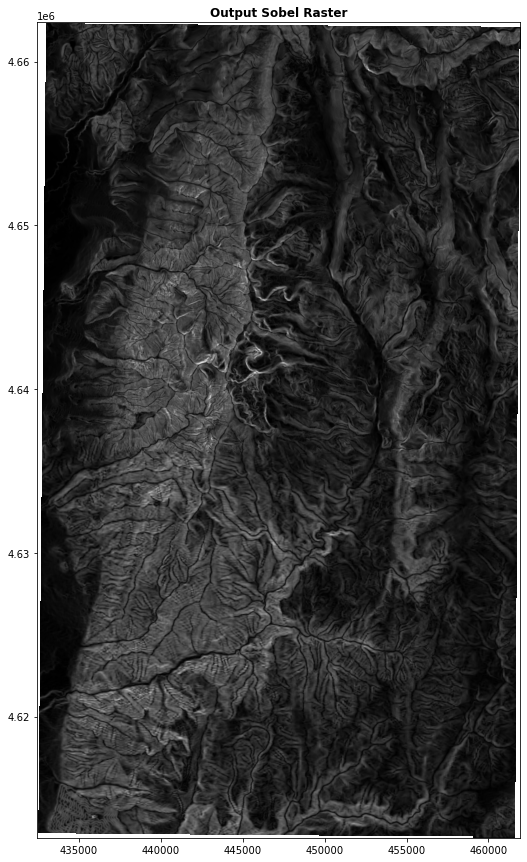

In [10]:
output_sobel = rasterio.open(out_sobel_raster)
plt.figure(figsize=(15,15))
show(output_sobel, cmap = "gray", title = "Output Sobel Raster")
#plt.show()